# Final Project: Money in European Soccer

## Part 2: Data Analysis and Deployment

In [74]:
# Imports for Data Cleaning and Analysis.

# Libraries for handling and plotting data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set()

# Libraries for modelling data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [25]:
# Accidentally forgot to save correct scrape so I hade to save this df
# test_df.to_csv('true_data.csv', index=False)
all_data_df = pd.read_csv('data/true_data.csv')

In [320]:
# Open scraped data (RIP all_datav4.pickle).
with open('data/all_datav3.pickle', 'rb') as handle:
    all_data = pickle.load(handle)

In [321]:
# Create super-dataframe containing each row is a season of a team.
def make_df(dct):
    data = {}
    data['league'] = []
    data['team'] = []
    data['season'] = []
    data['revenue'] = []
    data['spent'] = []
    data['goals'] = []
    data['competition'] = []
    data['position'] = []
    data['wins'] = []
    data['ties'] = []
    data['losses'] = []
    data['league_spent'] = []
    
    # Extract data from dictionary by appending all data from one season at a time. 
    for league in dct:
        for team in dct[league]:
            
            # All data of the same index in the dictionary's lists will be from the same season.
            for season in dct[league][team]:
                data['league'].append(league)
                data['team'].append(team)
                data['season'].append(season)
                for metric in dct[league][team][season]:
                    data[metric].append(dct[league][team][season][metric])
    return pd.DataFrame(data)


all_data_df = make_df(all_data)

In [3]:
# Our first look at our complete Dataframe.
# The null values in 'wins', 'ties', 'losses', and 'goals' are from the missing rows in the 'League rankings' pages.
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4342 entries, 0 to 4341
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   league               4342 non-null   object 
 1   team                 4342 non-null   object 
 2   season               4342 non-null   int64  
 3   revenue              4342 non-null   float64
 4   spent                4342 non-null   float64
 5   competition          4342 non-null   object 
 6   position             4342 non-null   object 
 7   wins                 3790 non-null   float64
 8   ties                 3790 non-null   float64
 9   losses               3790 non-null   float64
 10  league_spent         4342 non-null   float64
 11  relative             4277 non-null   float64
 12  net                  4342 non-null   float64
 13  goals_for            3790 non-null   float64
 14  goals_against        3790 non-null   float64
 15  5_season_agg         4342 non-null   f

### Data Engineering Challenges

#### Missing Data
&emsp; By far the biggest challenge I faced while feature engineering was accepting that I could not engineer certain features because I lacked the data for it. In future projects I will leave no stone unturned when searching for data because sometimes you only think of a feature you would like to analyze once you've already started engineering.

In [28]:
# Data Engineering

# All seasons that weren't in the 'First Tier' were by default lower than 10th place.
all_data_df['position'].loc[all_data_df.competition != 'First Tier'] = '≤10'

# Convert money into millions of euros.
def convert_money(X):
    if X == '-':
        X = '0'
    end = X[-1]
    if end == 'k':
        converted = float(X[1:-1])/1000
    elif end == 'm':
        converted = float(X[1:-1])
    elif end == 'n':
        converted = float(X[1:-2])*1000
    elif (end.isnumeric()) & (X[0] == '€'):
        converted = float(X.strip('€'))/1000000
    else:
        converted = float(X)
    return converted

# Apply 'convert_money' to all money features. 
all_data_df['spent'] = all_data_df['spent'].apply(convert_money)
all_data_df['revenue'] = all_data_df['revenue'].apply(convert_money)
all_data_df['league_spent'] = all_data_df['league_spent'].apply(convert_money)

# Create column for relative spend and net spend.
all_data_df['relative'] = all_data_df['spent'] / all_data_df['league_spent']
all_data_df['net'] = all_data_df['revenue'] - all_data_df['spent']

# Goals for and against columns.
def goals_for(X):
    if pd.isnull(X):
        return X
    else:
        indx = X.find(':')
        return X[:indx]

def goals_against(X):
    if pd.isnull(X):
        return X
    else:
        indx = X.find(':')
        return X[indx + 1:]

# Separate 'goals' column into 'goals_for' and 'goals_against'.
all_data_df['goals_for'] = all_data_df['goals'].apply(goals_for)
all_data_df['goals_against'] = all_data_df['goals'].apply(goals_against)
all_data_df = all_data_df.drop('goals', axis=1)

# Past 5 year transfer spend and net aggregate for teams and for leagues.
def aggregate_and_net(df):
    aggregates = []
    nets = []
    for club in df.team.unique():
        for i, row in df.loc[df.team == club].iterrows():
            aggregates.append(df[i:i+5].spent.sum())
            nets.append(df[i:i+5].net.sum())
    df['5_season_agg'] = aggregates
    df['5_season_net'] = nets
    return df

def league_aggregate(df):
    aggregates = []
    for club in df.team.unique():
        for i, row in df.loc[df.team == club].iterrows():
            aggregates.append(df[i:i+5].league_spent.sum())
    df['5_season_league_agg'] = aggregates
    return df

all_data_df = aggregate_and_net(all_data_df)
all_data_df = league_aggregate(all_data_df)

# Club 5 year relative spend.
all_data_df['5_season_relative'] = all_data_df['5_season_agg'] / all_data_df['5_season_league_agg']

# Convert positions to '10 or lower' for low league rankings.
all_data_df['position'] = all_data_df['position'].apply(lambda X: X if len(X) == 1 else '≤10')

# Create 'first_tier' column that tracks if a team is in the first tier league.
all_data_df['first_tier'] = all_data_df['competition'].apply(lambda X: 1 if X == 'First Tier' else 0)

# Convert int season to string.
all_data_df['season'] = all_data_df['season'].apply(lambda X: f'0{X}' if len(X) == 1 else str(X))

# Dataframe with all features.
all_data_df

,league,team,season,revenue,spent,competition,position,wins,ties,losses,league_spent,relative,net,goals_for,goals_against,5_season_agg,5_season_net,5_season_league_agg,5_season_relative,first_tier
0,England,Manchester City,23,162.17,155.00,First Tier,1,28.0,5.0,5.0,3100.000,0.050000,7.17,94.0,33.0,715.71,-267.14,9810.000,0.072957,1
1,England,Manchester City,22,93.80,138.90,First Tier,1,29.0,6.0,3.0,1710.000,0.081228,-45.10,99.0,26.0,878.21,-500.46,8890.000,0.098786,1
2,England,Manchester City,21,64.00,173.40,First Tier,1,27.0,5.0,6.0,1580.000,0.109747,-109.40,83.0,32.0,955.56,-636.26,8850.000,0.107973,1
3,England,Manchester City,20,71.00,169.82,First Tier,2,26.0,3.0,9.0,1790.000,0.094872,-98.82,102.0,35.0,990.63,-667.89,8730.000,0.113474,1
4,England,Manchester City,19,57.60,78.59,First Tier,1,32.0,2.0,4.0,1630.000,0.048215,-20.99,95.0,23.0,923.61,-641.57,8170.000,0.113049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,Ukraine,FK Oleksandriya,98,0.00,0.00,Not First,≤10,NaN,NaN,NaN,0.918,0.000000,0.00,NaN,NaN,0.00,0.00,1.318,0.000000,0
4338,Ukraine,FK Oleksandriya,97,0.00,0.00,Not First,≤10,NaN,NaN,NaN,0.400,0.000000,0.00,NaN,NaN,0.00,0.00,0.400,0.000000,0
4339,Ukraine,FK Oleksandriya,96,0.00,0.00,Not First,≤10,NaN,NaN,NaN,0.000,NaN,0.00,NaN,NaN,0.00,0.00,0.000,NaN,0
4340,Ukraine,FK Oleksandriya,95,0.00,0.00,Not First,≤10,NaN,NaN,NaN,0.000,NaN,0.00,NaN,NaN,0.00,0.00,0.000,NaN,0


## Data Visualization
&emsp; In this section I show some interesting figures that suggest a trend does exist between the amount of money spent in transfer fees and the league position of a team at the end of the season. In order to better understand the visuals displayed, here are some descriptions of the features being examined. Not all features were used for these visuals in the end.

#### League
&emsp; The league in which the team plays. I chose to use the name of the country instead of the league's actual name because I was only looking at positions in the top division of each country anyway.

#### Team
&emsp; The team who recorded these stats for this season. Not enough data to analyze the data of individual teams but this feature was helpful for finding the '5 season aggregate'.

#### Season
&emsp; The last two digits of the year this season ended.

#### Revenue
&emsp; The amount of money earned by a team from player sales that season in millions of euros.

#### Spent
&emsp; The amount of money spent by a team on player acquisition that season in millions of euros.

#### Competition
&emsp; The division in which the team played that season. 'First Tier' means the team played in the highest division of that country's professional soccer leagues.

#### Position
&emsp; The final league ranking of a team for that season. Unique values range from '1' to '≤10' and anything below the 'First Tier' is automatically lumped in with the '≤10' category.

#### Wins, Ties, and Losses
&emsp; These are among the most straightforward of features and undoubtedly have the highest correlation to position. The wins, ties, and losses over a season in the league determine that teams final league position.

#### League Spent
&emsp; The amount of money spent by all teams in the 'First Tier' for player acquisitions that season in millions of euros.

#### Relative
&emsp; Spent divided by League Spent. The relative money spent is perhaps the most important feature because it allows us to compare different leagues and different seasons with vastly different budgets from eachother.

#### Net
&emsp; The money earned minus the money spent by a team on player acquisition that season in millions of euros.

#### Goals For and Goals Against
&emsp; The goals scored for and the goals scored against a team that season.

#### 5_season_agg
&emsp; The amount of money spent by a team on player acquisition that season and four seasons prior combined in millions of euros.

#### 5_season_net
&emsp; The money earned minus the money spent by a team on player acquisition that season and four seasons prior combined in millions of euros.

#### 5_season_league_agg
&emsp; The amount of money spent by all teams in the 'First Tier' for player acquisitions that season and four seasons prior combined in millions of euros.

#### 5_season_relative
&emsp; 5 season aggregate divided by the 5 seasons league aggregate. Accomplishes the same things as 'relative' but comparing the past 5 seasons instead. This feature is less reliable however because there is no guarantee that the team was in the 'First Tier' over those 5 years and '5 season league aggregate' is a measure of the 'First Tier' spending.

#### first_tier
&emsp; A simple boolean feature to specify whether or not a team played in the 'First Tier' that season. Can be used to replace the competition column.

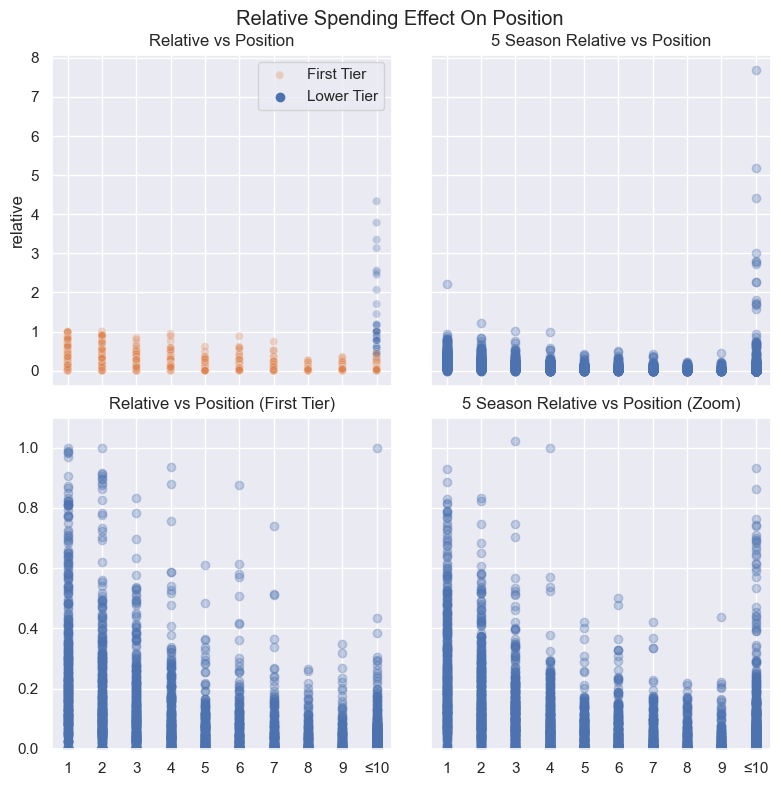

In [31]:
# Overall Relative Spending Plots
plot_df = all_data_df.copy()
plot_df = plot_df.drop(2502, axis=0)

# Order for yticks.
order = [str(x) for x in range(1,10)]
order.append('≤10')
plot_df['cat'] = pd.Categorical(plot_df.position, order)
plot_df = plot_df.sort_values(by='cat')

fig, ax = plt.subplots(2,2, sharex=True, sharey='row', figsize=(8,8))
fig.suptitle('Relative Spending Effect On Position')

fig.tight_layout()

# All leagues 'Relative vs Position'.    
pvr_df = plot_df[['position', 'relative', 'first_tier']].dropna()

sns.scatterplot(data=pvr_df, x='position', y='relative', hue='first_tier', alpha=0.3, ax=ax[0][0])
ax[0][0].set_title('Relative vs Position')
ax[0][0].legend(labels=['First Tier', 'Lower Tier'])

# All leagues '5 year Relative vs Position'
pv5yr_df = plot_df[['position', '5_season_relative']].dropna()

ax[0][1].scatter(pv5yr_df.position, pv5yr_df['5_season_relative'], alpha=0.3)
ax[0][1].set_title('5 Season Relative vs Position')

# All leagues 'Relative vs Position' for first tier teams.    
pvr_df = plot_df[['position', 'relative', 'first_tier']].loc[plot_df.first_tier == 1].dropna()

ax[1][0].scatter(pvr_df.position, pvr_df.relative, alpha=0.3)
ax[1][0].set_title('Relative vs Position (First Tier)')


# All leagues '5 year Relative vs Position' with cutoff.
pv5yr_df = plot_df[['position', '5_season_relative']].dropna()

ax[1][1].scatter(pv5yr_df.position, pv5yr_df['5_season_relative'], alpha=0.3)
ax[1][1].set_title('5 Season Relative vs Position (Zoom)')

# Cut off points above 1.0 to better see the effect.
ax[1][1].set_ylim([0,1.1]);

> These plots show the overall trend of relative spending by position.

>The two scatter plots on the left side show the relative spending of and club and their final league position where each point represents a season for a team. The top left scatter plot separates the 'First Tier' teams from the lower division teams by colour and the bottom left one shows the same plot but without the lower division teams.

>The bottom right scatter plot is the same as the top right one but with a y-axis limit to be able to better examine the trend.

In [341]:
# Exploring strange points in the plots.
plot_df[['league','season','team','spent','league_spent','relative']].loc[(plot_df.relative > 1)&(plot_df.league_spent != 0)]

,league,season,team,spent,league_spent,relative
3544,Scotland,98,Celtic FC,7.47,6.40,1.167187
3542,Scotland,00,Celtic FC,21.43,14.81,1.446995
3541,Scotland,01,Celtic FC,30.54,14.78,2.066306
3540,Scotland,02,Celtic FC,12.18,4.85,2.511340
3539,Scotland,03,Celtic FC,6.04,2.36,2.559322
3574,Scotland,98,Rangers FC,15.68,6.40,2.450000
3573,Scotland,99,Rangers FC,41.84,9.66,4.331263
3572,Scotland,00,Rangers FC,15.20,14.81,1.026334
3571,Scotland,01,Rangers FC,46.33,14.78,3.134641
3570,Scotland,02,Rangers FC,18.35,4.85,3.783505


&emsp; Having a relative spending higher than the 1.0 doesn't make sense unless, for some reason, you are in a lower division and spending more than all of the teams in the first tier combined. Upon inspection of the data source, these values were all found where they were expected to be found so the data scraping was not found to be faulty but, instead, the data source appeared to be providing conflicting information.

This is a consequence of trying to gather data on less popular leagues like the Scottish Premiership or the Russian Premier Liga.  

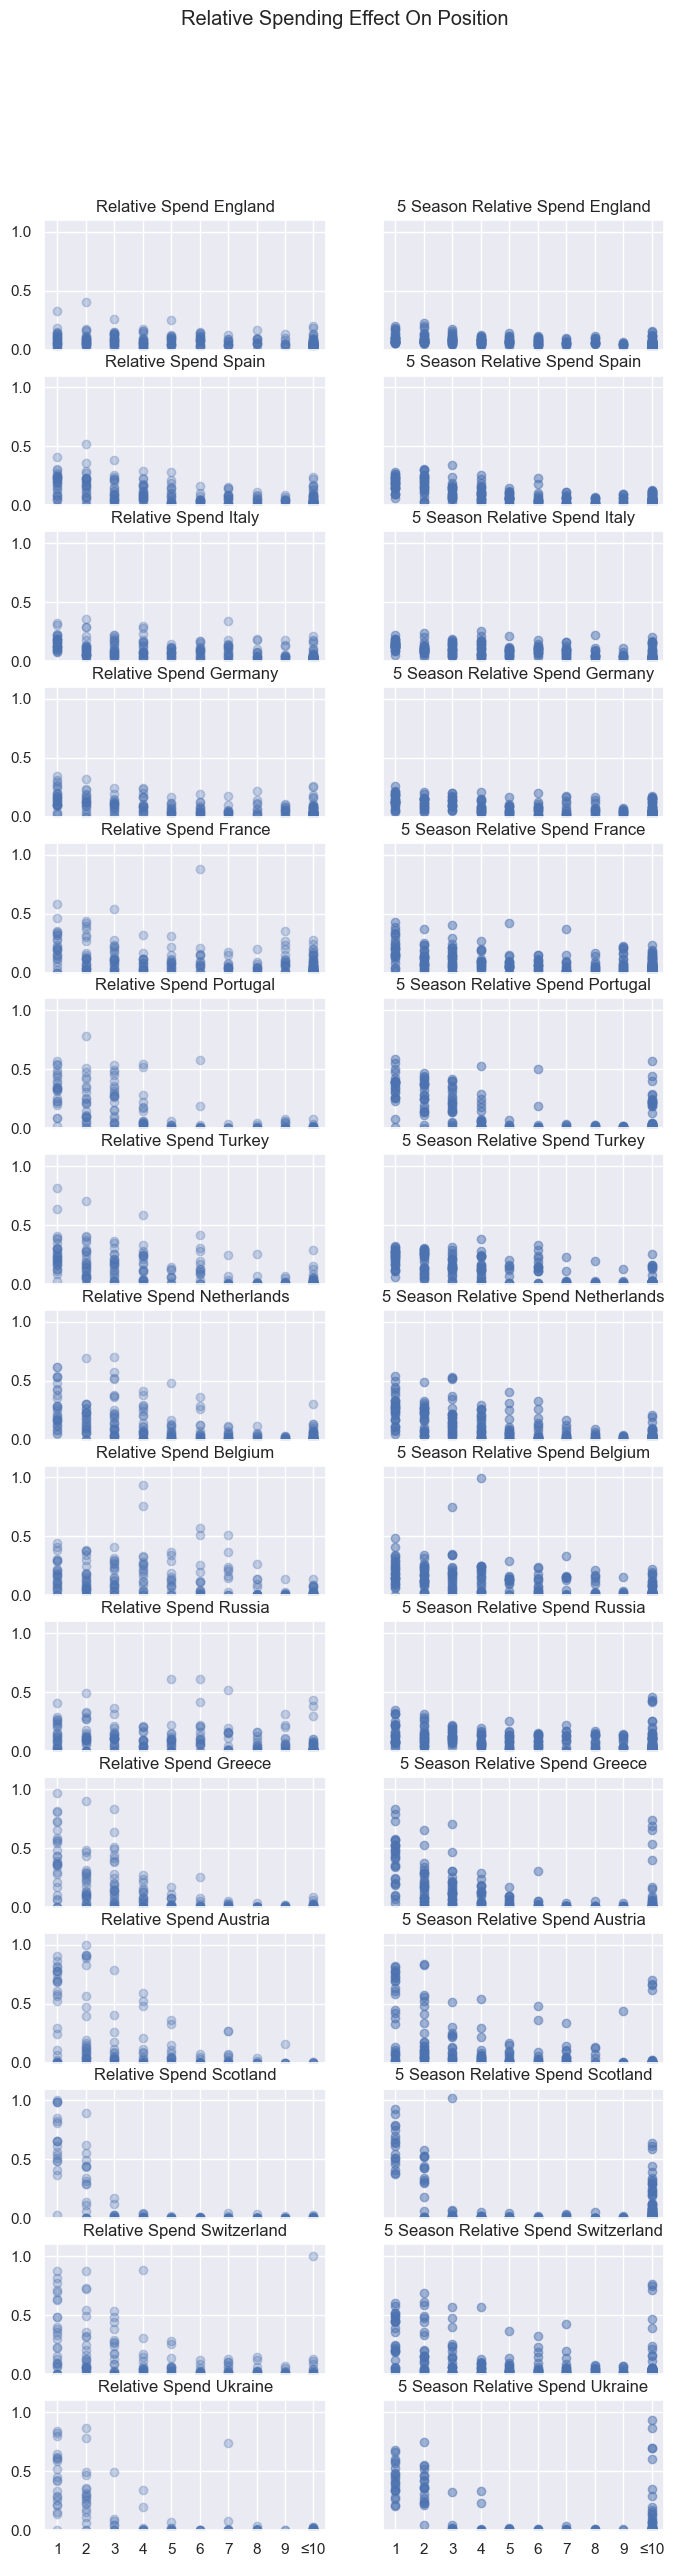

In [342]:
# Relative Spending plots for each league.
leagues = all_data_df.league.unique()

fig, ax = plt.subplots(len(leagues),2, sharex=True, sharey='row', figsize=(8,30))
fig.suptitle('Relative Spending Effect On Position', y=0.95)

for i, league in enumerate(leagues):
    plt_df = plot_df.loc[plot_df.league == league]
    
    # All leagues 'Relative vs Position'.    
    pvr_df = plt_df[['position', 'relative', 'first_tier']].loc[plot_df.first_tier == 1].dropna()

    ax[i][0].scatter(pvr_df.position, pvr_df.relative, alpha=0.3)
    ax[i][0].set_title(f'Relative Spend {league}')


    # All leagues '5 year Relative vs Position'
    pv5yr_df = plt_df[['position', '5_season_relative']].dropna()

    ax[i][1].scatter(pv5yr_df.position, pv5yr_df['5_season_relative'], alpha=0.5)
    ax[i][1].set_title(f'5 Season Relative Spend {league}')
    ax[i][1].set_ylim([0,1.1])
    

> These plots show the same Position vs Relative relationship of as seen above but for the individual leagues. You can tell which leagues are the most competitive by comparing the relative spending of the positions.

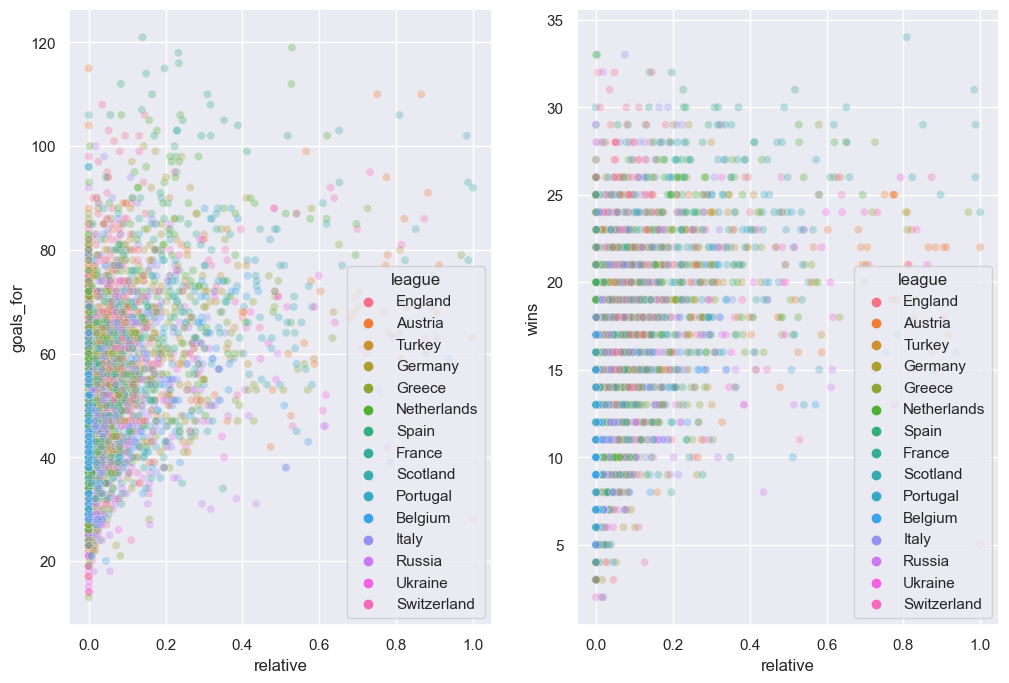

In [9]:
# Other Features vs Relative Spending. 
features = ['goals_for', 'wins']

fig, ax = plt.subplots(1,2, figsize=(12,8))

for i, feature in enumerate(features):
    feat_df = plot_df[[feature, 'relative', 'league']].dropna()
    sns.scatterplot(x=feat_df.relative, y=feat_df[feature].astype('int'), hue=feat_df.league, alpha=0.3, ax=ax[i])

> These two scatter plots compare the relative spending to other features tied to success, 'goals for' and 'wins'. Both plots show a similar trend of higher relative spending reducing the chance a low amount of 'goals for' or 'wins.

C:\Users\luisa\AppData\Local\Temp\ipykernel_45600\1697525247.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



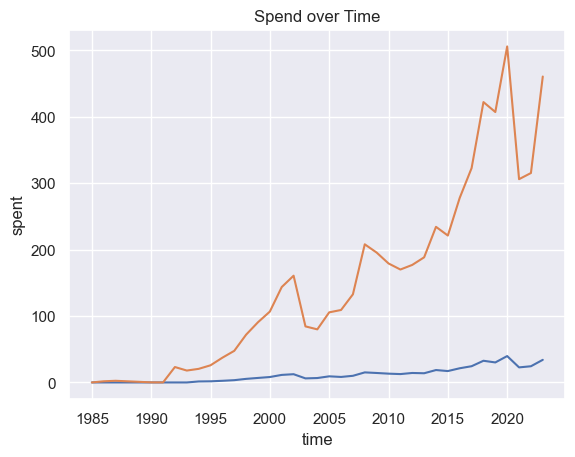

In [55]:
# Average Club and League Spending over time.
time_df = plot_df.groupby('season').mean()
time_df['time'] = pd.to_datetime(time_df.index, format='%y')
time_df = time_df.set_index('time')


for feature in ['spent', 'league_spent']:
    sns.lineplot(data=time_df, x=time_df.index, y=feature, ).set_title('Spend over Time')

> This line plot demonstrates the change in average transfer spend over time. It shows how valuable relative spending is as a feature because transfer spend values from earlier seasons would otherwise be hard to compare to more recent ones. 

In [10]:
# Choropleth map info preparation.

# Load geojson file.
with open('data/europe.geojson') as response:
    countries = json.load(response)

# Change 'United Kingdom' to 'England' (geojson file doesn't separate England and Scotland).
for i, country in enumerate(countries['features']):
    if country['properties']['NAME'] == 'United Kingdom':
        countries['features'][i]['properties']['NAME'] = 'England' 

### Dashboard

In [73]:
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    html.Div(className='row', children='Effect of Spending on League Position in Europe', style={'text-align':'center','fontSize':50}),
    html.Hr(),
    html.Div(className='row', children=[
        html.Div(className='position', children=[dash_table.DataTable(data=all_data_df[['league', 'team', 'season', 'relative', '5_season_relative']].to_dict('records'), page_size=10)], style={'width': '50%', 'display': 'inline-block'}),
        html.Div(className='position', children=[dcc.Graph(figure={}, id='position-graph')], style={'width':'50%', 'display':'inline-block'})
    ]),  
    html.Div(className='row', children=[dcc.RadioItems(options={'relative': 'Relative Spending', '5_season_relative': 'Relative Spending (5 seasons)'}, value='relative', inline=True, labelStyle = {'margin-left':'10px'}, style={'float':'right', 'padding-right':180}, id='position-radio')]),
    html.Div(className='row', children=[
        html.Div(className='choro', children=[dcc.Graph(figure = {}, id='choro-graph')], style={'flex-grow':3}),
        html.Div(className='choro', children=[dcc.Graph(figure = {}, id='hist-graph')], style={'flex-grow':1}),
        
        
    ], style={'display':'flex', 'justify-content':'space-between', 'align-items':'flex-end', 'margin-bottom':0}),
    html.Div(className='row', children=[
        html.Div(className='options', children=[dcc.Slider(1, 10,                                                         
                                                         marks={
                                                             1: '1',
                                                             2: '2',
                                                             3: '3',
                                                             4: '4',
                                                             5: '5',
                                                             6: '6',
                                                             7: '7',
                                                             8: '8',
                                                             9: '9',
                                                             10: '≤10'
                                                         },
                                                         value=1, id='choro-slider')
                                                ], style={'width': '50%', 'flex-grow':1}),
        html.Div(className='choro', children=[dcc.Dropdown(['England',
                                                            'Spain',
                                                            'Italy',
                                                            'Germany',
                                                            'France',
                                                            'Portugal',
                                                            'Turkey',
                                                            'Netherlands',
                                                            'Belgium',
                                                            'Russia',
                                                            'Greece',
                                                            'Austria',
                                                            'Scotland',
                                                            'Switzerland',
                                                            'Ukraine',],
                                                           'England',
                                                           id='hist-drop')
                                                ], style={'width':'30%','padding-left':150, 'flex-grow':1})
    ], style={'display':'flex', 'justify-content':'flex-start', 'margin-top':0}),
    html.Div(className='row', children=[
        html.Div(className='spend', children=[dcc.RadioItems(options={'spent':'Team Spend', 'league_spent':'League Spend'},
                                                            value='spent',
                                                            style={'flex':'1'},
                                                            id='spent-radio')]),
        html.Div(className='spend', children=[dcc.Graph(figure = {}, id='spent-graph')], style={'flex':'1'}),
        html.Div(className='spend', children=[dcc.Graph(figure = {}, id='league-graph')], style={'flex':'1'})
    ],style={'display':'flex', 'justify-content':'center', 'align-items':'center'})
])

@callback(
    Output(component_id='position-graph', component_property='figure'),
    Input(component_id='position-radio', component_property='value')
)
def update_graph(col):
    if col == 'relative':
        df = pvr_df
    else:
        df = pv5yr_df
    
    fig = px.scatter(df, x='position', y=col)
    fig.update_layout(title_text='Position vs Relative Spending', title_x=0.5)
    return fig

@callback(
    Output(component_id='choro-graph', component_property='figure'),
    Input(component_id='choro-slider', component_property='value')
)
def update_choro(position):
    if position == 10:
        position = '≤10'
    df = all_data_df.loc[all_data_df.position == str(position)].groupby('league').mean(numeric_only=True)
    fig = px.choropleth(df, geojson=countries, locations=df.index, featureidkey='properties.NAME', color='relative',
                        color_continuous_scale="Viridis",
                        range_color=(0, 0.6),
                        scope="europe",
                        labels={'relative':'Relative Spend',
                                 'league': 'Country'},
                        height=600,
                        width=800
                        )
    fig.update_layout(title_text='Average Relative Spend by Position', title_x=0.5)
    return fig

@callback(
    Output(component_id='hist-graph', component_property='figure'),
    Input(component_id='hist-drop', component_property='value')
)
def update_hist(league):
    df = all_data_df.loc[all_data_df.league == league].groupby('position').mean(numeric_only=True)
    fig = px.histogram(df, x=df.index, y='relative')
    fig.update_layout(title_text=f'Average Relative Spend by Position in {league}', title_x=0.5)
    fig.update_xaxes(title_text='Position')
    fig.update_yaxes(title_text='Average Relative Spend', range=[0,0.6])
    return fig

@callback(
    Output(component_id='spent-graph', component_property='figure'),
    Input(component_id='spent-radio', component_property='value')
)
def update_line(scope):
    if scope == 'spent':
        title = 'Team Spend'
    else:
        title = 'League Spend'
        
    df = time_df.sort_index()
    fig = px.line(df, x=df.index, y=scope)
    fig.update_layout(title_text=f'Average {title} over Time', title_x=0.5)
    fig.update_xaxes(title_text='Year')
    fig.update_yaxes(title_text='Millions of Euros (€)')
    return fig

@callback(
    Output(component_id='league-graph', component_property='figure'),
    Input(component_id='hist-drop', component_property='value')
)
def update_league(league):
    df = plot_df.loc[plot_df.league == league].groupby('season').mean(numeric_only=True)
    df['time'] = pd.to_datetime(df.index, format='%y')
    df = df.set_index('time')
    df = df.sort_index()
    fig = px.line(df, x=df.index, y='league_spent')
    fig.update_layout(title_text=f'Average League Spend over Time: {league}', title_x=0.5)
    fig.update_xaxes(title_text='Year')
    fig.update_yaxes(title_text='Millions of Euros (€)')
    return fig

if __name__ == '__main__':
    app.run(jupyter_mode='external', debug=True)

Dash app running on http://127.0.0.1:8050/


C:\Users\luisa\AppData\Local\Temp\ipykernel_45600\3208102231.py:133: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\luisa\AppData\Local\Temp\ipykernel_45600\3208102231.py:133: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\luisa\AppData\Local\Temp\ipykernel_45600\3208102231.py:133: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\luisa\AppData\Local\Temp\ipykernel_45600\3208102231.py:133: FutureW

### Classification Model

In [82]:
# Building a classification model based solely on relative spend.
class_df = all_data_df[['relative','position']].loc[all_data_df.relative != float('inf')].dropna()

X = class_df.relative.array.reshape(-1, 1)
y = class_df.position

# Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

# Create and fit model.
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain and evaluate predictions.
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred, labels=class_df.position.unique())

0.44557556773688334


array([[ 53,   0,   0,   0,   0,  86,   0,   0,   0,   0],
       [ 31,   0,   0,   0,   0,  80,   0,   0,   0,   0],
       [ 15,   0,   0,   0,   0,  87,   0,   0,   0,   0],
       [  6,   0,   0,   0,   0,  75,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,  75,   0,   0,   0,   0],
       [ 20,   0,   0,   0,   0, 516,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  54,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  48,   0,   0,   0,   0],
       [  4,   0,   0,   0,   0,  60,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,  64,   0,   0,   0,   0]], dtype=int64)

&emsp;The one feature classification model won't perfectly predict the final position of a team based solely on their spending relative to the league's overall spending because there are thankfully still factors outside of money that determine the outcome of a league campaign. Though the game continues to attract wealthy investors keen on seeing their team win trophies, upsets and underdog stories remain an everpresent, cherished part of soccer that gives fans hope.